In [70]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt


## Visualiza los conjuntos de datos

Grafica la tasa de deposición de polvo del conjunto de datos empíricos en las ubicaciones de medición y los datos simulados en la cuadrícula global.

In [71]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [72]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [73]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Genera un gráfico de mapa de la deposición de polvo basado en el dataframe proporcionado.

    Parámetros:
    - df (pandas DataFrame): El dataframe que contiene los datos de deposición de polvo.
    - title(str): El título que se mostrará en el gráfico.
    - name_to_save (str): El nombre de archivo para guardar el gráfico de mapa generado.
    - label_str (str, opcional): El nombre de la columna en el dataframe para usar como etiqueta de los datos en el gráfico. Por defecto, 'log_dep'.
    - measure_units (str, opcional): Las unidades de medida para el flujo de polvo. Por defecto, 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, opcional): El valor límite para la barra de color en el gráfico. Por defecto, 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Establecer los límites y marcas
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Graficar mapa mundial
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Graficar el GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Establecer etiquetas y título
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Guardar y mostrar el gráfico
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


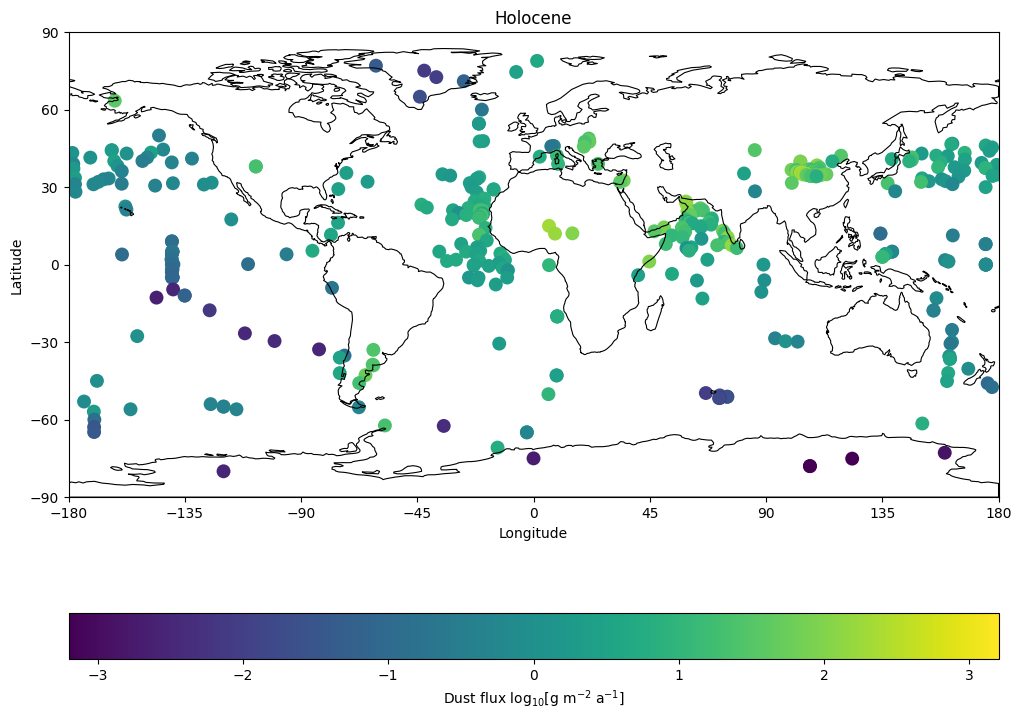

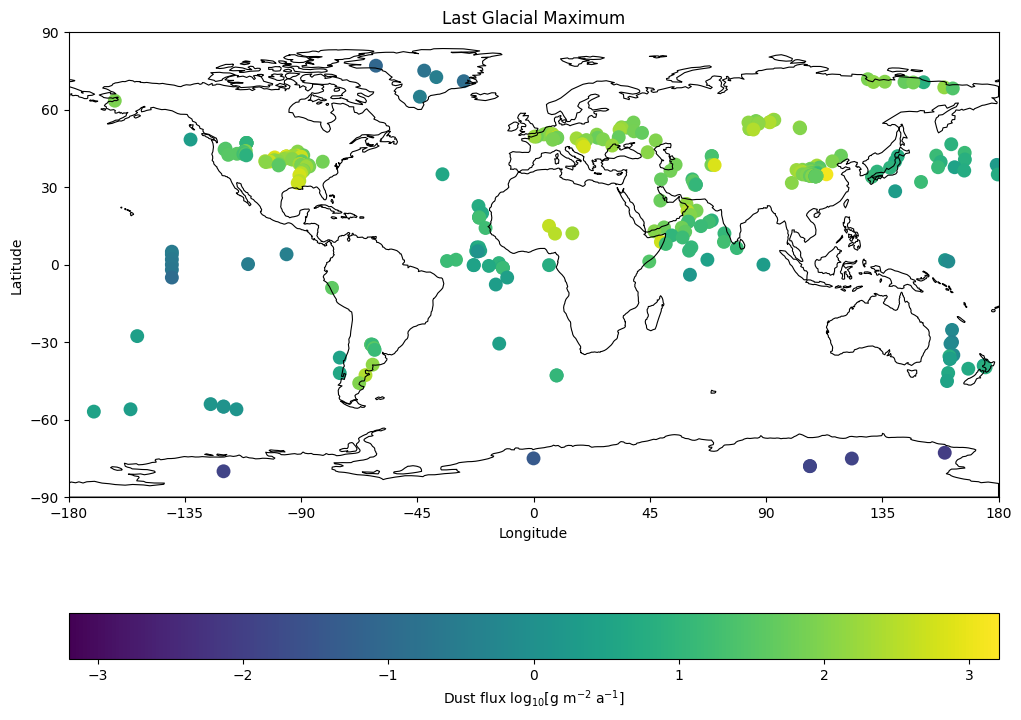

In [74]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Crear y visualizar la cuadrícula global

La cuadrícula global para las predicciones consiste en un espaciado de 3 grados.

In [75]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

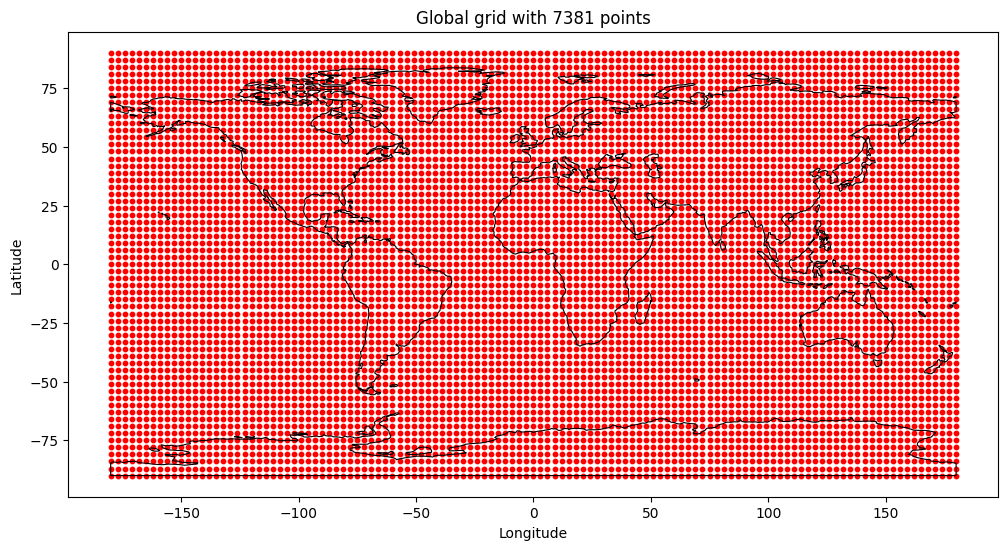

In [76]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analizar la tasa de deposición global con los vecinos más cercanos

La tasa de deposición de polvo se estimará promediando los valores de los $k$ vecinos más cercanos.

In [77]:
def distance_euclidean(x, y):
    """
    Calcular la distancia euclidiana entre dos puntos.
    
    Parámetros:
    x, y : Iterable
    Vectores para la ubicación 2D de los dos puntos.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

In [78]:
#ejemplo para verificar el funcionamiento de la distancia euclidiana
ejemplo1=distance_euclidean((-33.45959880479925, -70.61116238517187),(42.781438544823494, -76.22268697250844))
print(ejemplo1)

76.44726930597882


In [79]:
import math
def distance_geodesic(x, y):
    """
    Calcular la distancia geodésica entre dos puntos en la Tierra.

    Parámetros:
    x, y : Iterable
    Vectores para la ubicación 2D de los dos puntos.
    """
    R=6371
    numeropi=math.pi
    latitud_x=((x[0])*numeropi)/180
    longitud_x=((x[1])*numeropi)/180
    latitud_y=((y[0])*numeropi)/180
    longitud_y=((y[1])*numeropi)/180
    # Esta conversión es necesaria ya que la longitud y latitud se mide en grados
    # decimales y la distancia geodésica entregada se mide en radianes

    a=math.sin(latitud_x)
    b=math.sin(latitud_y)
    c=math.cos(latitud_x)
    d=math.cos(latitud_y)
    e=math.cos(longitud_y-longitud_x)

    arccos=math.acos((a*b)+(c*d*e))
    distancia=R*arccos
    
    return distancia


In [80]:
# Ejemplo para verificar la distancia geodesica
ejemplo=distance_geodesic((-33.45959880479925, -70.61116238517187),(42.781438544823494, -76.22268697250844))
print(ejemplo)

8496.856641672463


In [81]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Realiza una estimación de los k vecinos más cercanos.

    Parámetros:
    df : pandas.DataFrame
        La base de datos.
    x : Iterable
       Ubicación para la estimación.
    k : int
       El número de vecinos a considerar.
    dist : str
         El tipo de definición de distancia.
    """
    
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

In [82]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5


## Función de los vecinos cercanos con distancia Euclidiana

In [83]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

In [84]:
df_global_grid

,lon,lat,est_hol,est_lgm
0,-180.0,-90.0,-0.736623,-0.111441
1,-177.0,-90.0,-0.736623,-0.111441
2,-174.0,-90.0,-0.736623,-0.175193
3,-171.0,-90.0,-0.736623,-0.175193
4,-168.0,-90.0,-0.740268,-0.175193
...,...,...,...,...
7376,168.0,90.0,0.388114,1.583464
7377,171.0,90.0,0.388114,1.583464
7378,174.0,90.0,0.388114,1.583464
7379,177.0,90.0,0.388114,1.583464


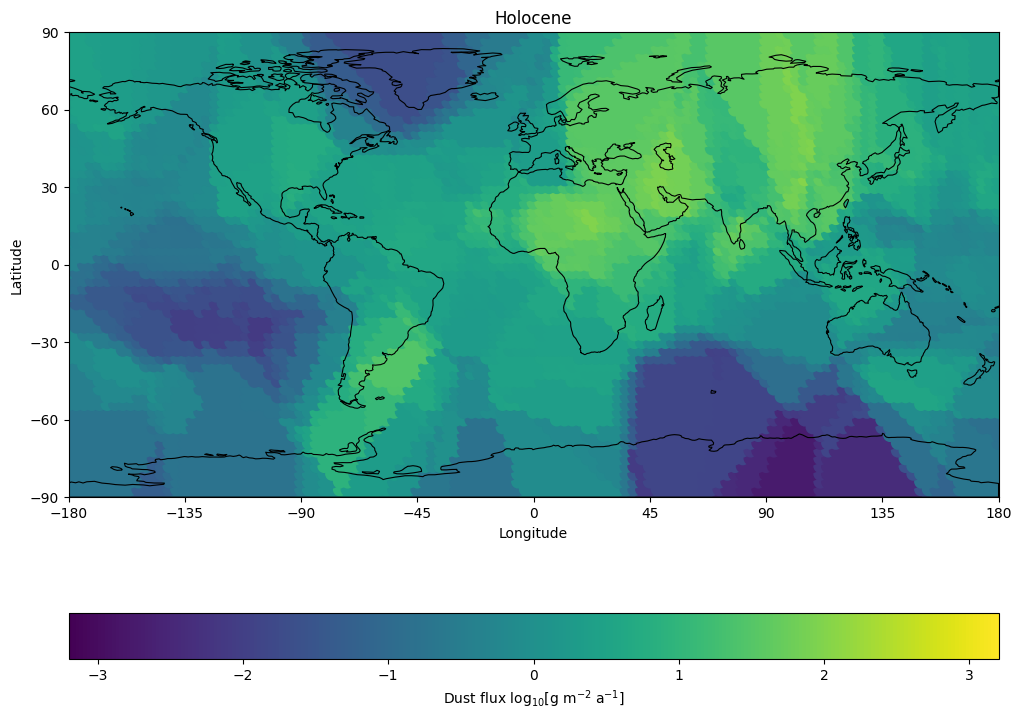

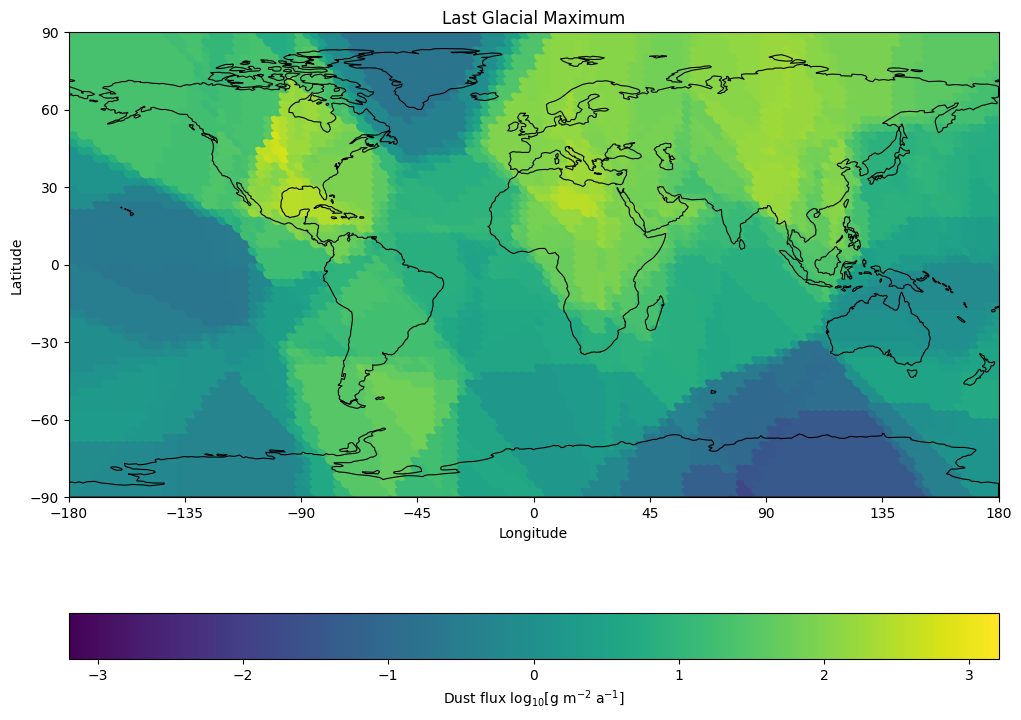

In [85]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

## Función de los vecinos cercanos con distancia geodesica:

In [86]:
estimations_holocene_geodesic = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_geodesic = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_geodesic[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist="geodesic")
    estimations_lgm_geodesic[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist="geodesic")
    #se está llamando a la función de los vecinos más cercanos para Holocene y LGM

df_global_grid["est_hol_geodesic"] = estimations_holocene_geodesic
df_global_grid["est_lgm_geodesic"] = estimations_lgm_geodesic

In [87]:
df_global_grid

,lon,lat,est_hol,est_lgm,est_hol_geodesic,est_lgm_geodesic
0,-180.0,-90.0,-0.736623,-0.111441,-0.943857,0.336214
1,-177.0,-90.0,-0.736623,-0.111441,-0.943857,-0.531728
2,-174.0,-90.0,-0.736623,-0.175193,-0.611015,-0.531728
3,-171.0,-90.0,-0.736623,-0.175193,-0.611015,-0.531728
4,-168.0,-90.0,-0.740268,-0.175193,-0.611015,-0.271522
...,...,...,...,...,...,...
7376,168.0,90.0,0.388114,1.583464,-0.000511,0.965428
7377,171.0,90.0,0.388114,1.583464,-0.000511,0.965428
7378,174.0,90.0,0.388114,1.583464,-0.000511,0.965428
7379,177.0,90.0,0.388114,1.583464,-0.000511,0.988117


## Visualización del método de vecinos cercanos con distancia geodésica


El código de visualización fue entregado por chatgpt al preguntarle por una forma de visualización. Fue necesario recurrir a esta herramienta ya que yo no he cursado Introducción a la Ciencia de Datos y, por lo tanto, no he tenido los conocimientos sobre visualización de datos.

Primero con Holoceno


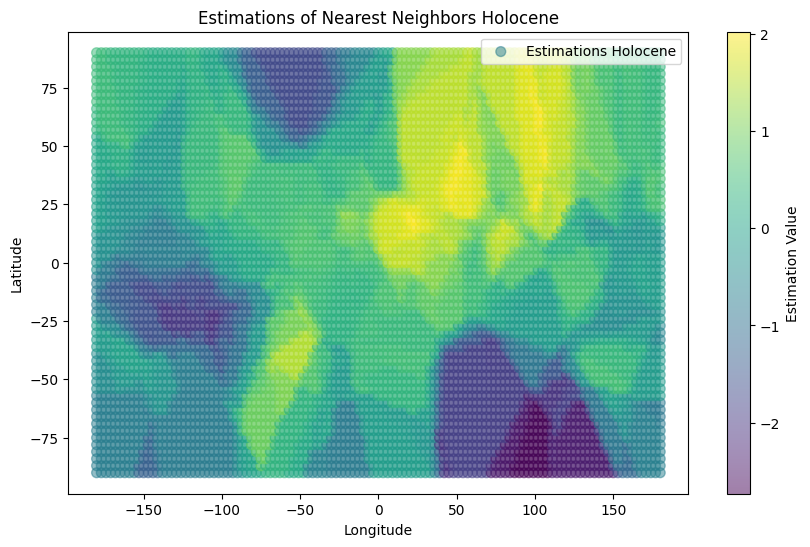

In [88]:
import matplotlib.pyplot as plt

# Crear un gráfico de dispersión
plt.figure(figsize=(10, 6))

# Scatter plot para las estimaciones de Holoceno
plt.scatter(df_global_grid['lon'], df_global_grid['lat'], c=df_global_grid['est_hol'], cmap='viridis', s=50, alpha=0.5, label='Estimations Holocene')


# Agregar barra de color
plt.colorbar(label='Estimation Value')

# Agregar etiquetas y leyenda
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Estimations of Nearest Neighbors Holocene')
plt.legend()

# Mostrar el gráfico
plt.show()

Ahora con LGM


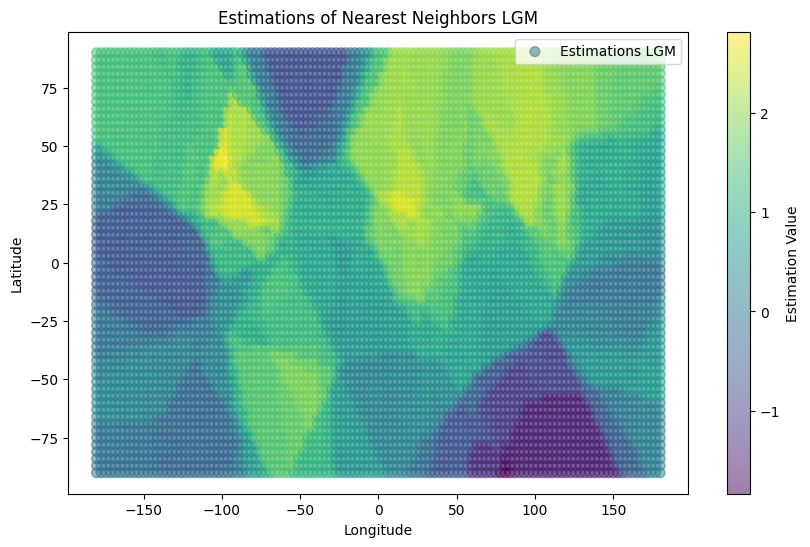

In [89]:
# Crear un gráfico de dispersión
plt.figure(figsize=(10, 6))

# Scatter plot para las estimaciones de Último Máximo Glacial
plt.scatter(df_global_grid['lon'], df_global_grid['lat'], c=df_global_grid['est_lgm'], cmap='viridis', s=50, alpha=0.5, label='Estimations LGM')

# Agregar barra de color
plt.colorbar(label='Estimation Value')

# Agregar etiquetas y leyenda
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Estimations of Nearest Neighbors LGM')
plt.legend()

# Mostrar el gráfico
plt.show()

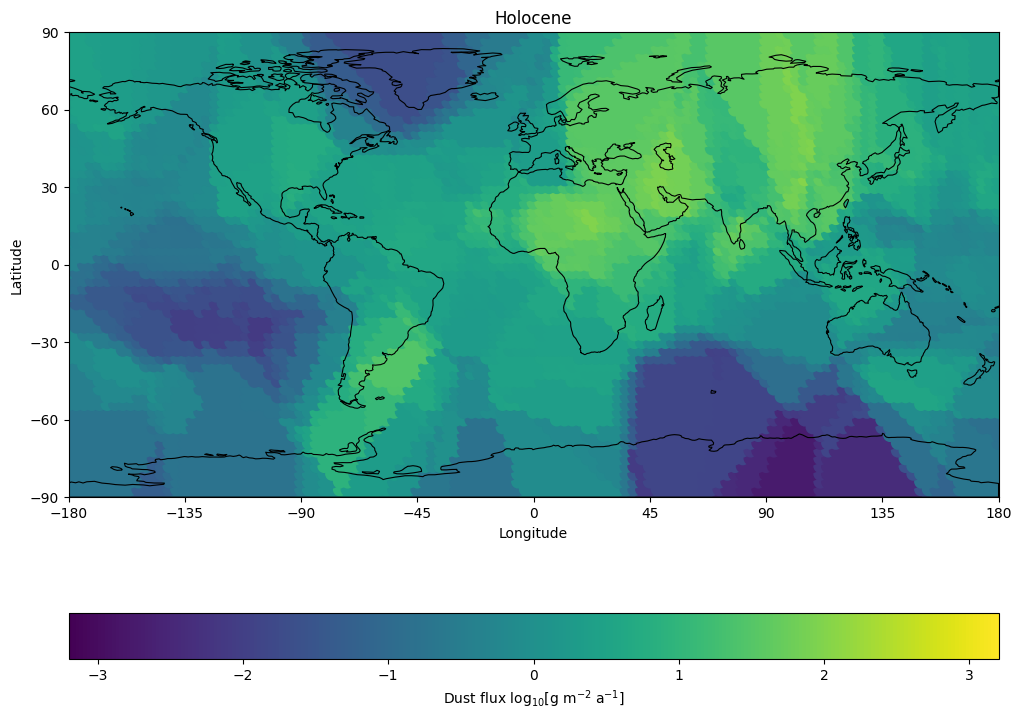

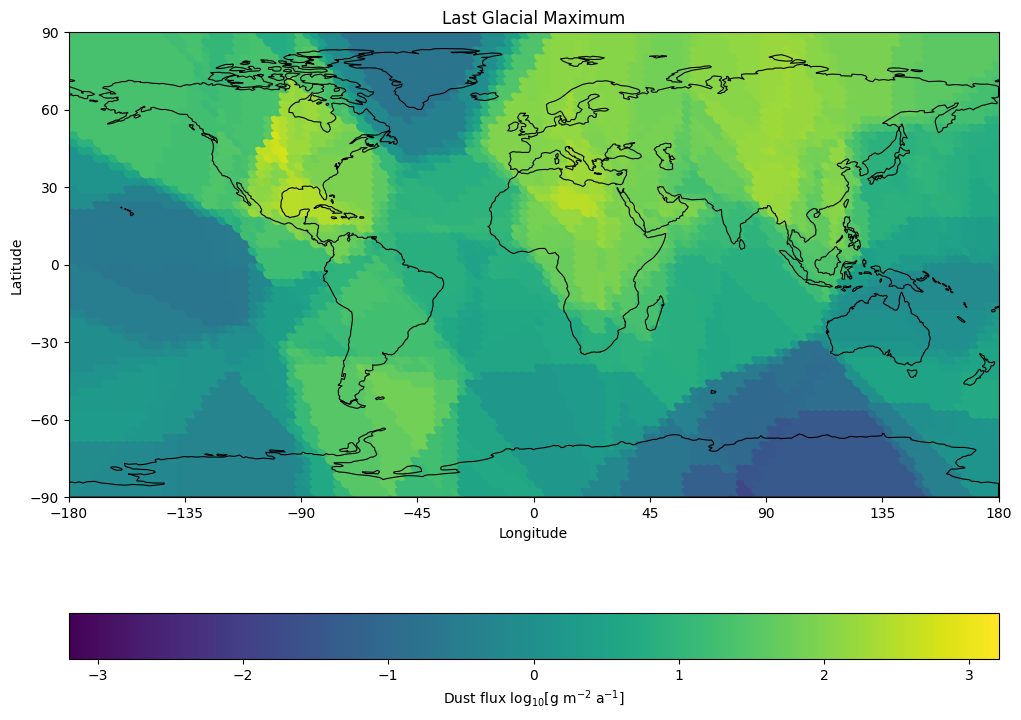

In [90]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

## Cálculo de la diferencia entre los dos métodos


Primero comparamos en el caso de Holoceno, entre distancia euclidiana y geodesica.

In [91]:
diferencia=df_global_grid["est_hol"]-df_global_grid["est_hol_geodesic"]
print(diferencia)

0       0.207234
1       0.207234
2      -0.125608
3      -0.125608
4      -0.129252
          ...   
7376    0.388625
7377    0.388625
7378    0.388625
7379    0.388625
7380    0.388625
Length: 7381, dtype: float64


Visualización de la diferencia entre el Holoceno con distancia euclidiana y Holoceno con distancia geodesica. Código de chatgpt, misma razón que la anterior.

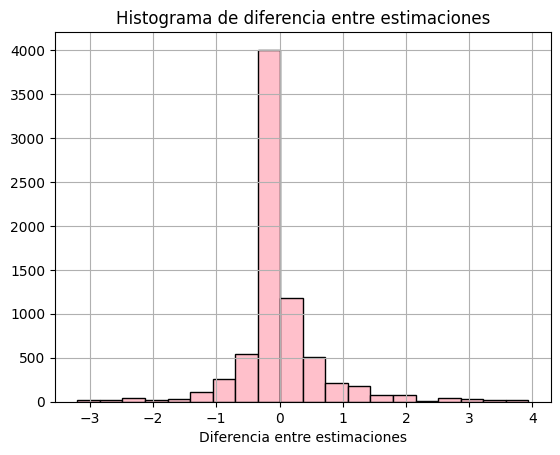

In [92]:
plt.hist(diferencia, bins=20, color='pink', edgecolor='black')
plt.xlabel('Diferencia entre estimaciones')
plt.ylabel('')
plt.title('Histograma de diferencia entre estimaciones')
plt.grid(True)
plt.show()

Ahora comparamos el caso de LGM, entre distancia euclidiana y geodesica.

In [93]:
diferencia2=df_global_grid["est_lgm"]-df_global_grid["est_lgm_geodesic"]
print(diferencia2)

0      -0.447655
1       0.420286
2       0.356535
3       0.356535
4       0.096329
          ...   
7376    0.618035
7377    0.618035
7378    0.618035
7379    0.595347
7380    0.595347
Length: 7381, dtype: float64


Visualización de la diferencia entre el LGM con distancia euclidiana y LGM con distancia geodesica. Código de chatgpt, misma razón que la anterior.

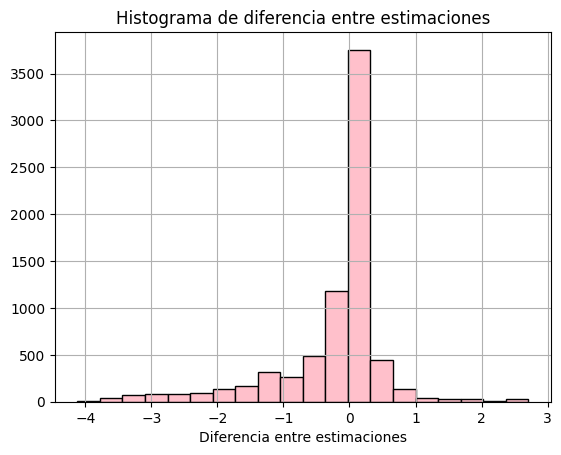

In [94]:
plt.hist(diferencia2, bins=20, color='pink', edgecolor='black')
plt.xlabel('Diferencia entre estimaciones')
plt.ylabel('')
plt.title('Histograma de diferencia entre estimaciones')
plt.grid(True)
plt.show()

## ¿Por qué los resultados son distintos?


Las diferencias nacen principalmente del hecho de que la distancia euclidiana se utiliza para medir superficies planas y la Tierra es esférica, por lo tanto, la distancia que uno pueda calcular con la medida eucliniana, no considerará la curvatura del planeta. La distancia euclidiana asumirá a la superficie como plana, y no calculará el arco que representa la curatura planetaria. 

Hay diferencias más grandes que otras al calcular las dos distancias. Esta diferencia se debe a que, en primer lugar, todo de pende de la elección de los puntos a los cuales queremos calcularles la distancia. Mientras más cercanos se encuentren, la diferencia entre la distancia euclidiana y geodésica será menor. En cambio, al escoger puntos más separados, la diferencia entre ambas distancias es mucho más notable, considerando que una tomará la curvatura planetaria y la otra no. 

Para ser aún más específicos, el planeta Tierra no tiene forma de una esfera perfecta, sino más bien un elipsoide, achatado en los polos. Esto significa que en estas zonas, o sea, en los polos, la diferencia entre las dsitancias será menor, ya que por una cierta cantidad de distancia, los polos se parecen a un plano. Pero justamente por esta razón, que sólo se parezca, la distancia euclidiana sigue sin ser la más apropiada, ya que seguimos sin hablar de un plano. Cabe agregar que esta misma forma de elipsoide con los polos achatados hace que las áreas cercanas a los polos sean mayormente pronunciadas, por lo que la distancia geodésica sería mucho más acertada en estos puntos. 

En la longitud 180º también es más recomendable utilizar la distancia geodésica, considerando que el contorno se asemeja a una letra c, es una curvatura no despreciable. 

Entre la visualización de la diferencia en el Holoceno y en LGM encontramos puntos de parecido y puntos en que difieren. Ambos tienen una acentuación de diferencia de distancias marcada cercana al 0, pero para el Holoceno esta acentuación es acercándose desde el -1 y para LGM la acentuación es acercándose desde 1.

La información sobre la forma de la Tierra fue leída desde: http://planetario.unlp.edu.ar/divulgacion/que-forma-tiene-la-tierra-ya-te-aviso-no-es-redonda-373#:~:text=La%20Tierra%20es%20una%20pelota,de%20forma%20con%20el%20tiempo.